Aggregated Results (Averages):
         R^2           MSE       RMSE       MAE          MAPE       dataset  \
0   0.552642  4.628631e+00   2.150825  1.523289  1.512075e-01       abalone   
1   0.867278  1.556846e+02  12.477041  8.271618  1.080978e+01  superconduct   
2  -0.403219  2.356149e-07   0.000463  0.000317  2.333651e+08      Ailerons   
3   0.447314  4.255934e-01   0.650822  0.348675  1.034948e+14     house_16H   
4   0.555101  4.607490e+00   2.145362  1.524103  1.501858e-01       abalone   
..       ...           ...        ...       ...           ...           ...   
80  0.688537  1.007325e-01   0.317249  0.236369  1.946790e-02        houses   
81  0.465687  4.098844e-01   0.639566  0.343043  1.002463e+14     house_16H   
82  0.944337  5.724072e-02   0.239242  0.188256  2.437929e-02      diamonds   
83  0.371847  4.790047e-01   0.691700  0.537846  9.532271e-02  wine_quality   
84  0.887714  5.064919e-06   0.002243  0.001611  7.486551e-02     elevators   

          model  
0 

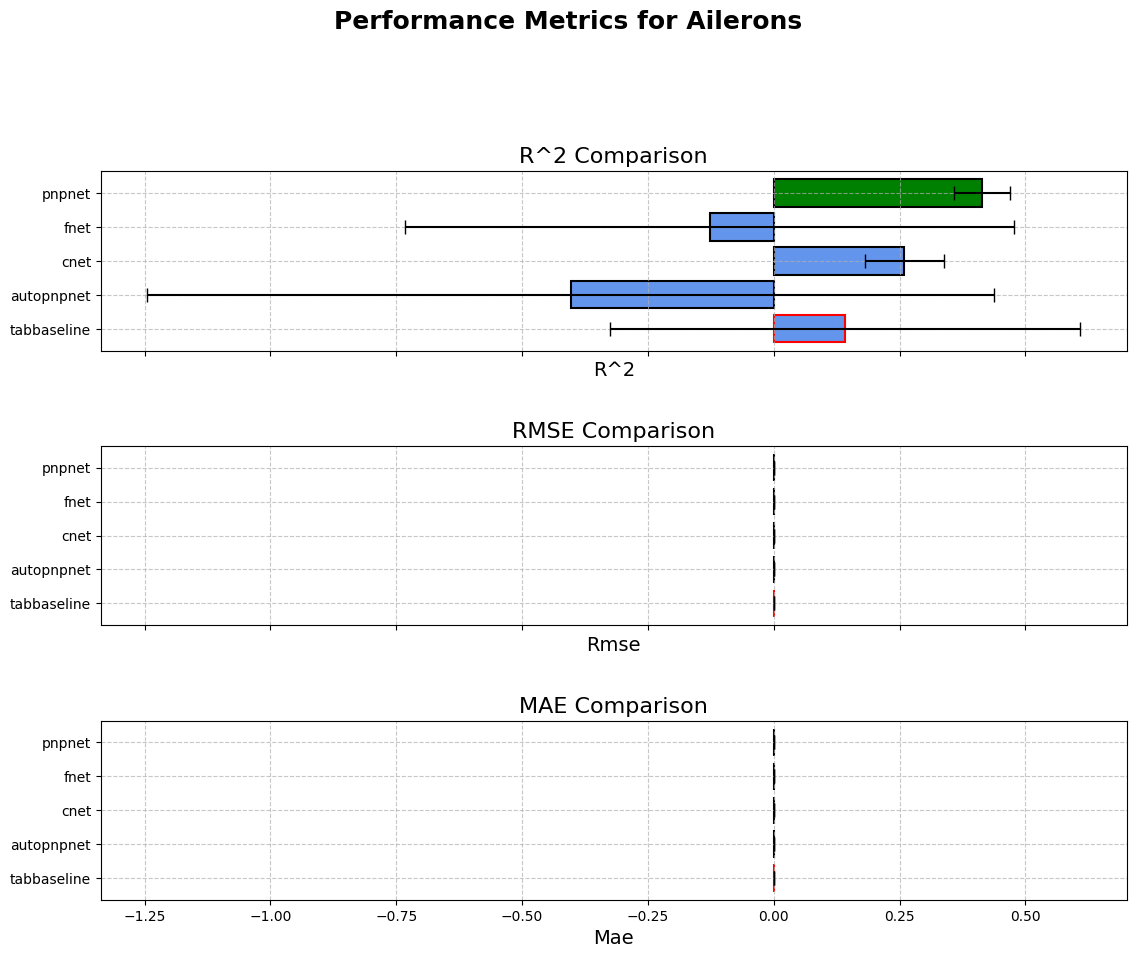

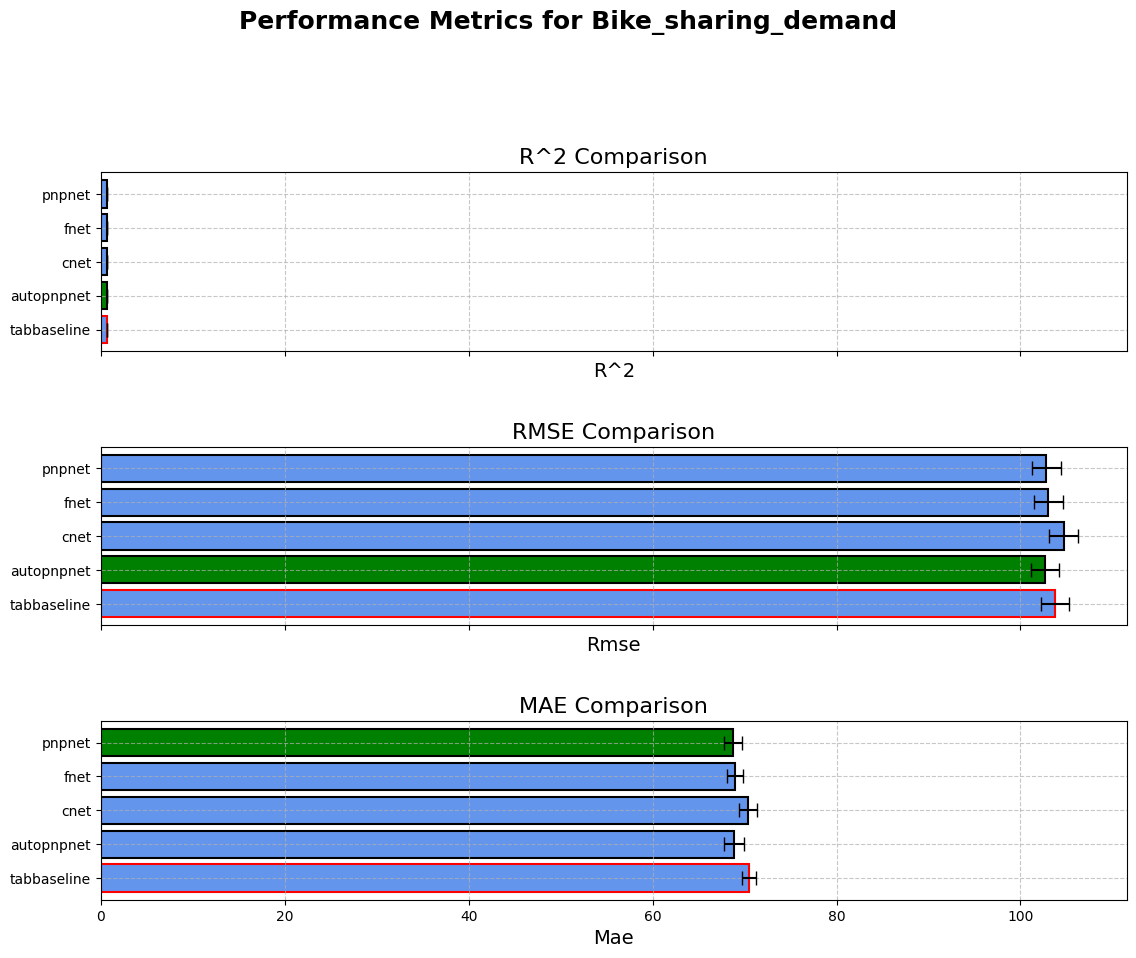

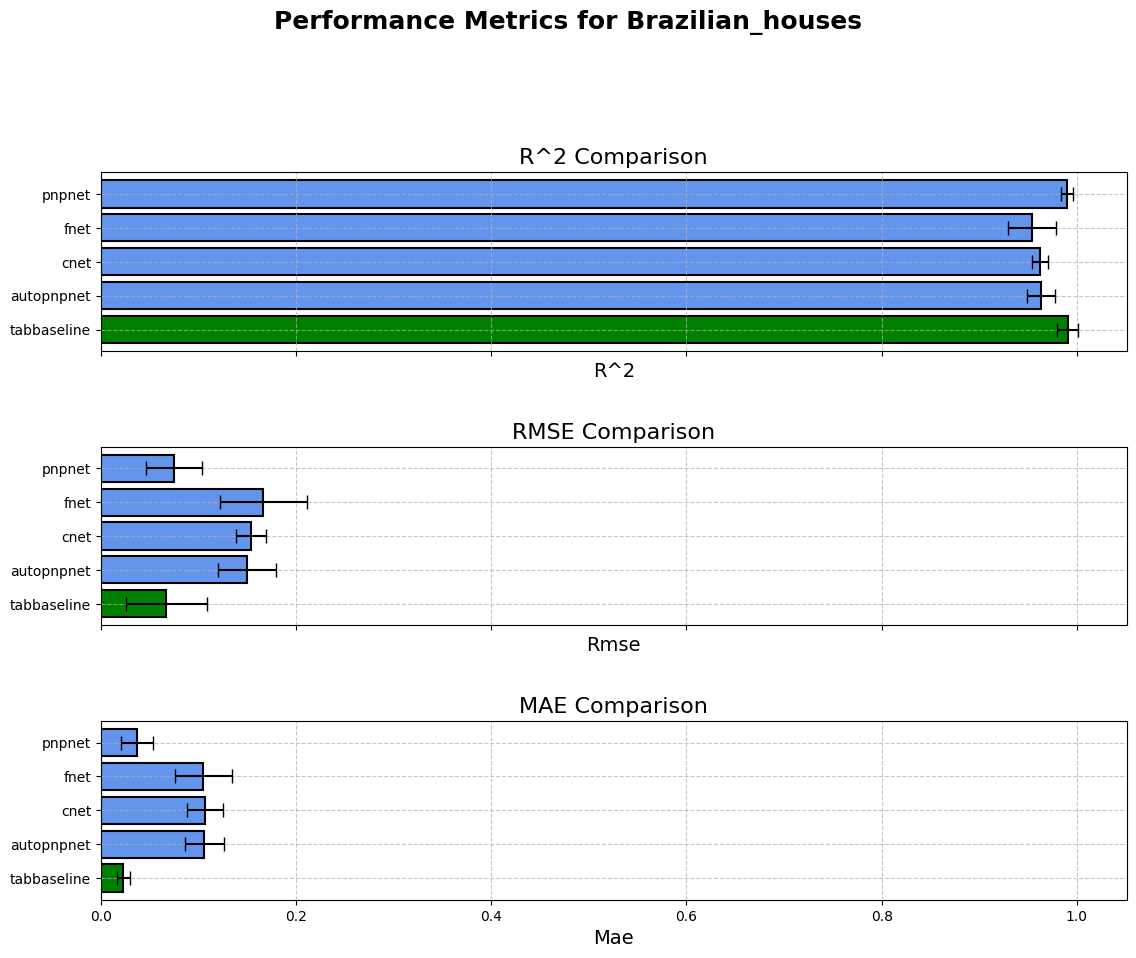

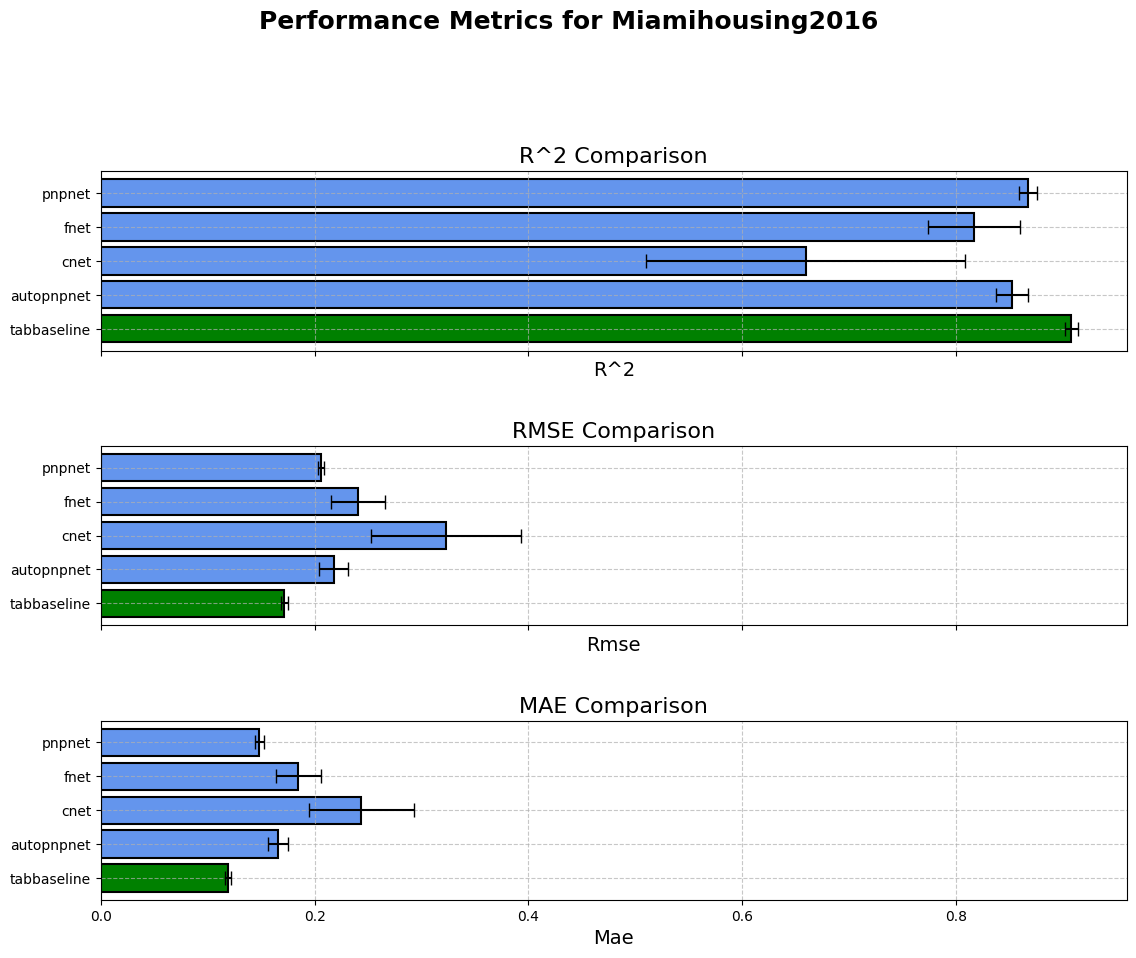

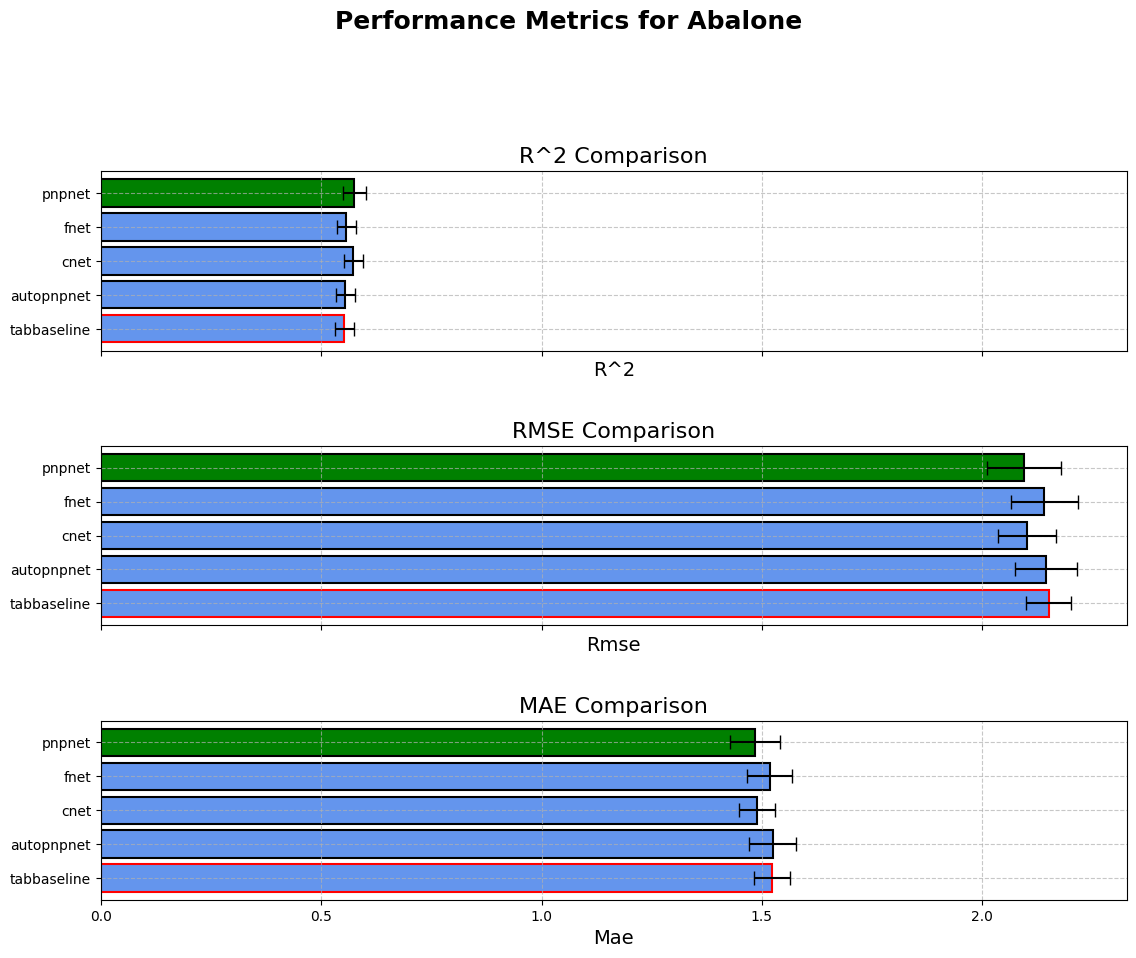

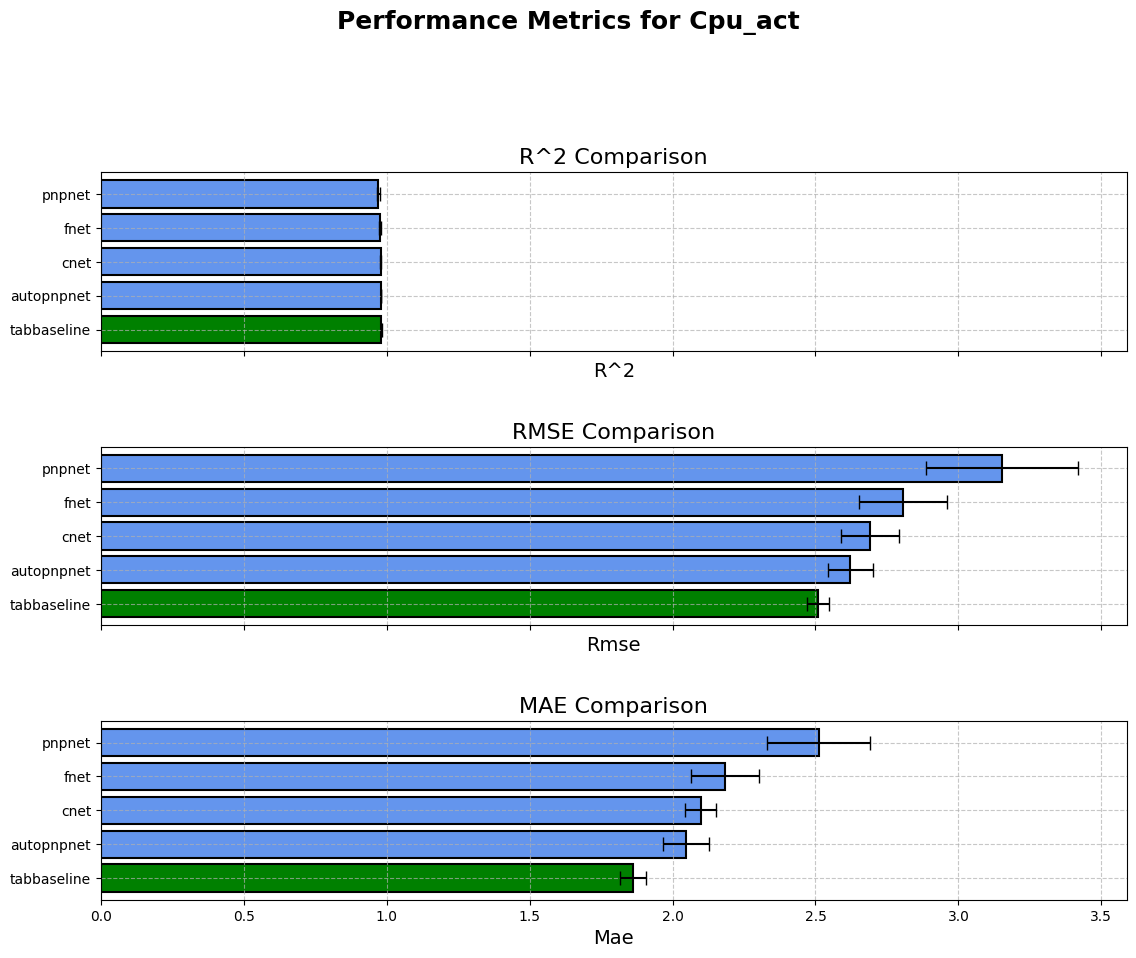

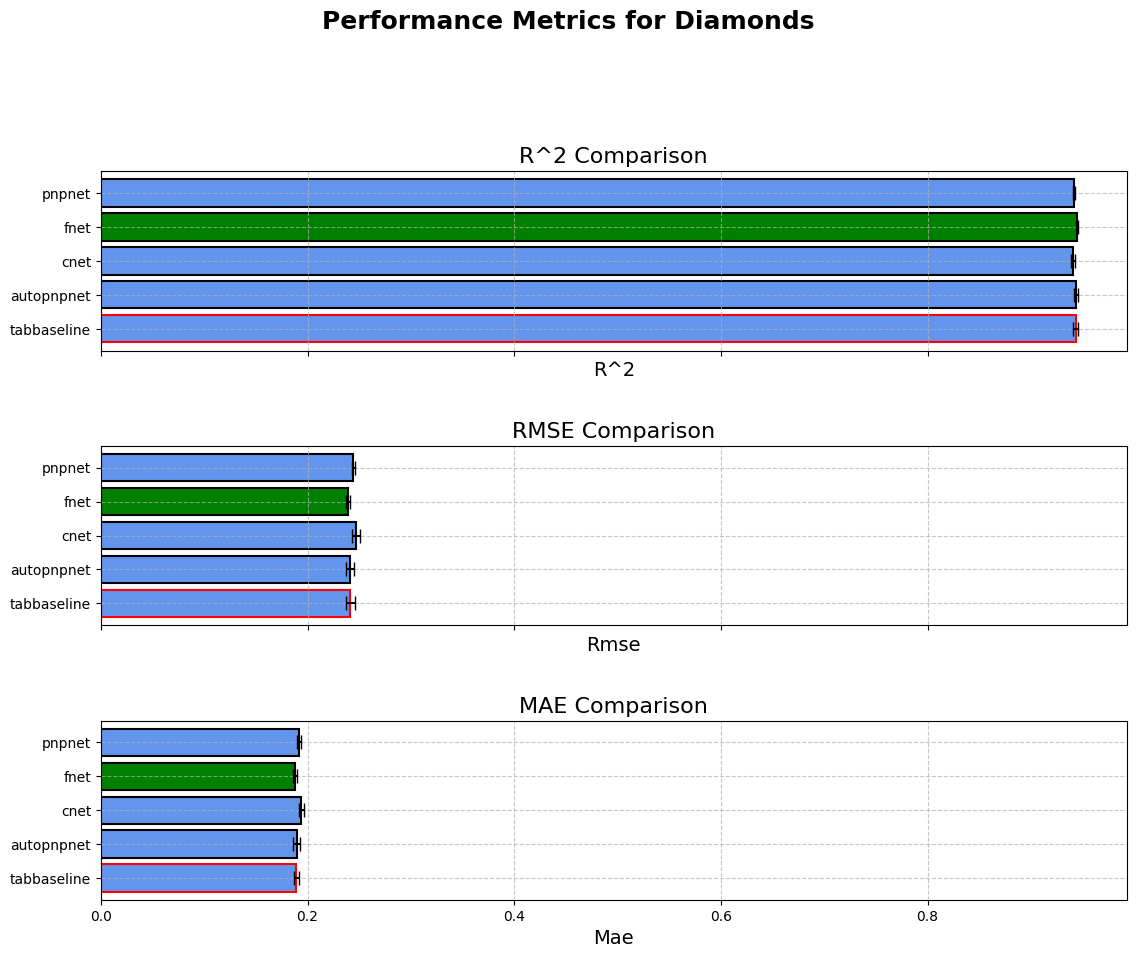

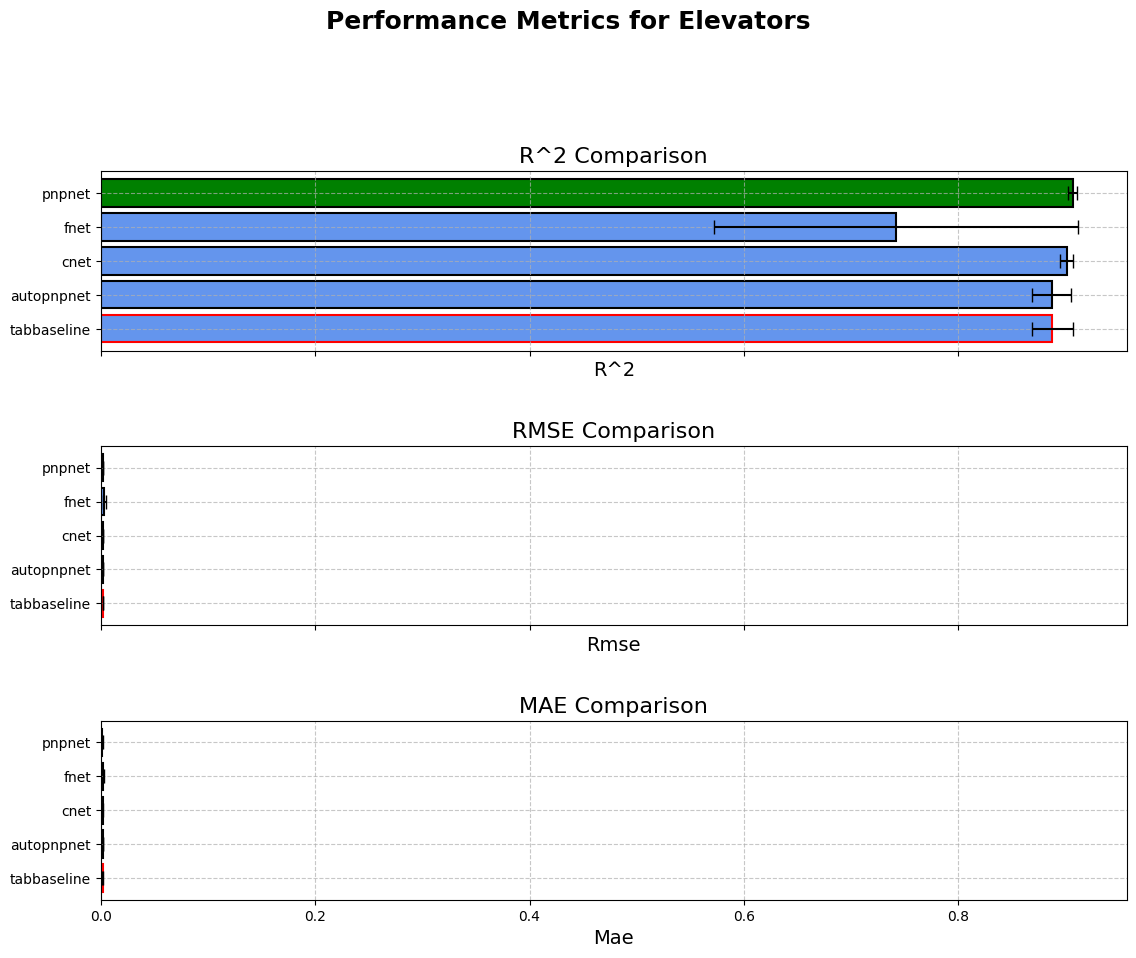

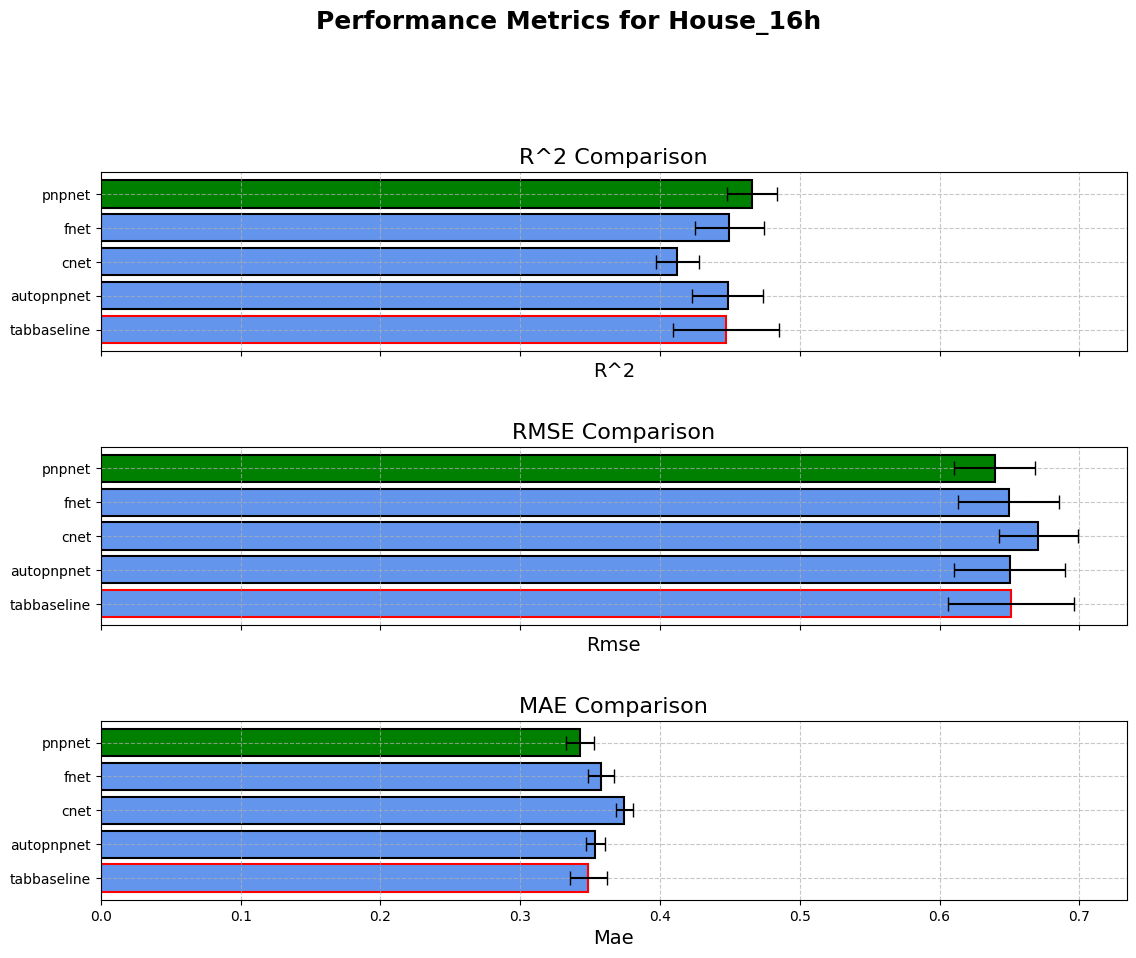

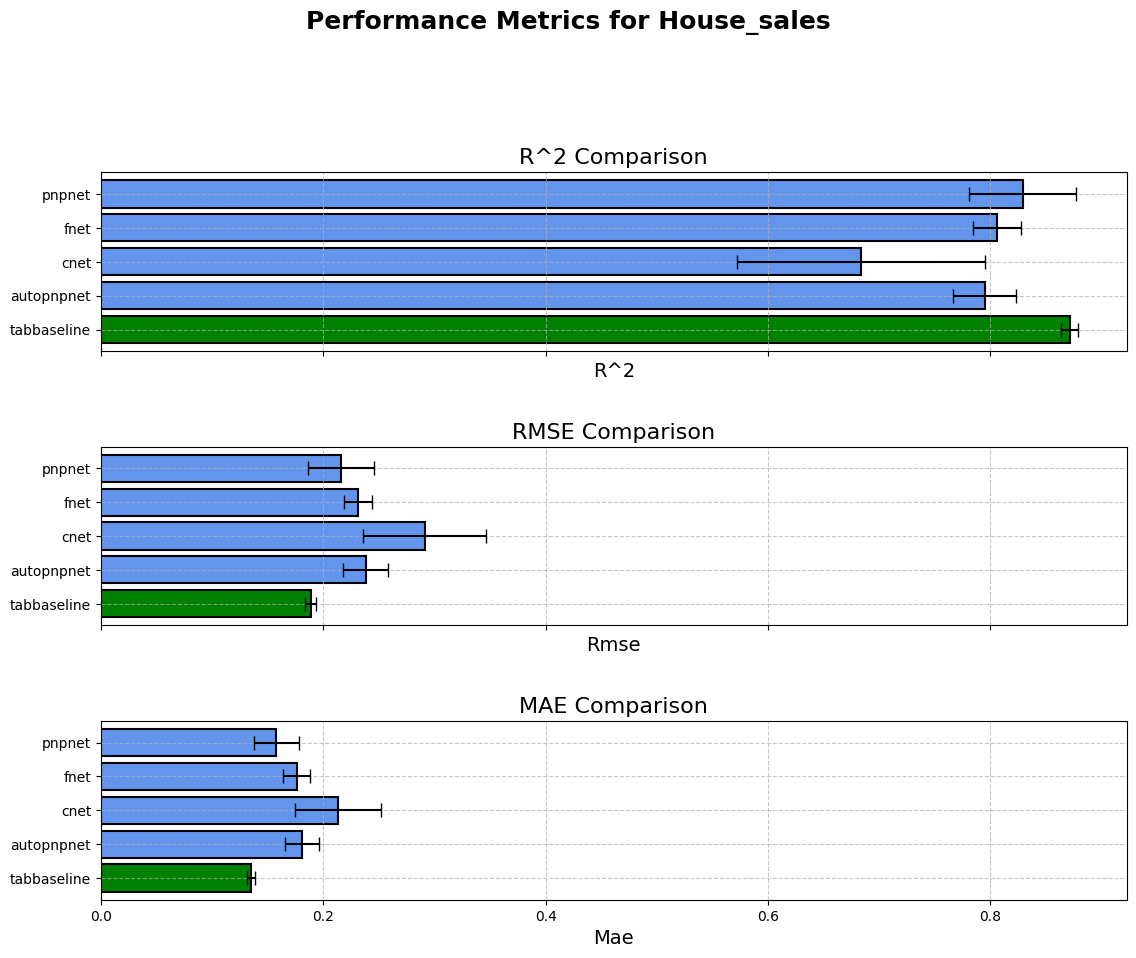

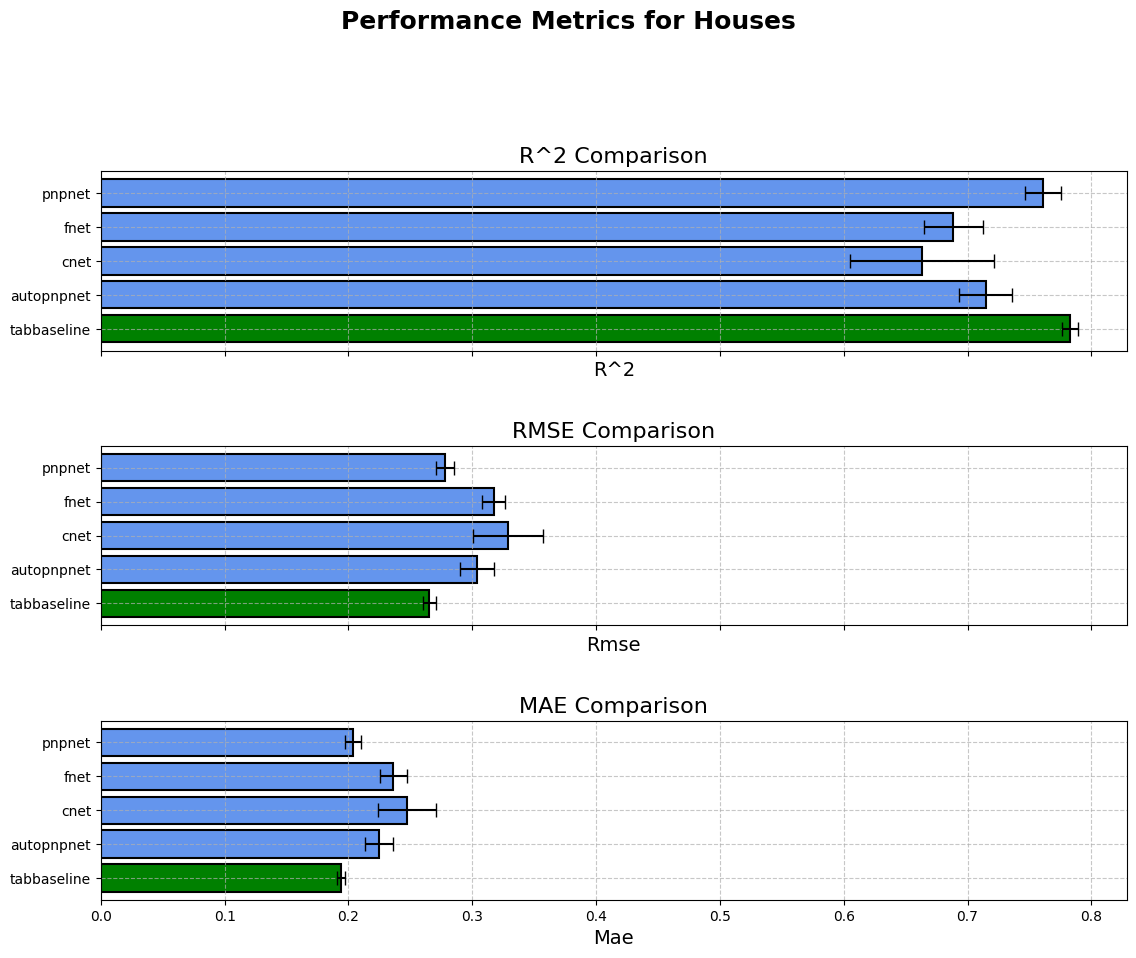

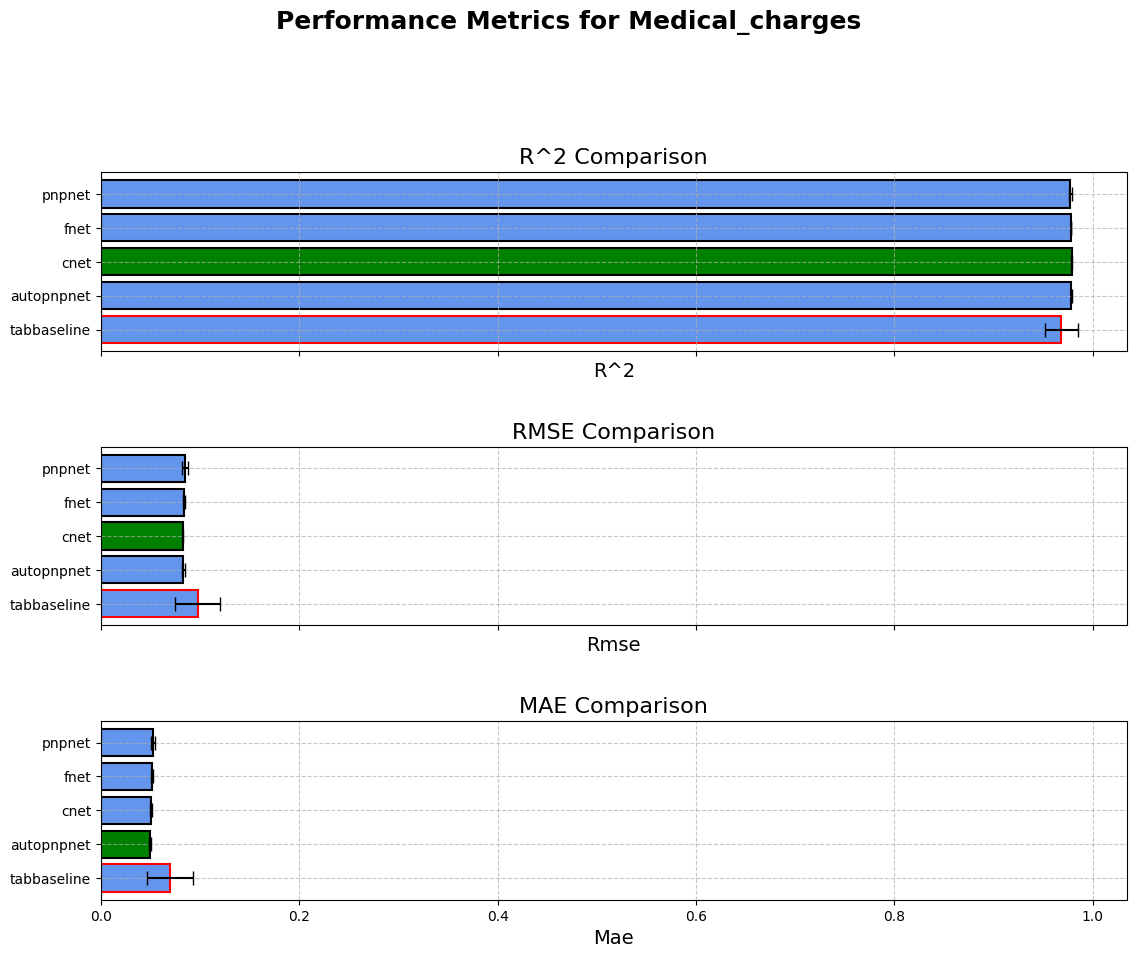

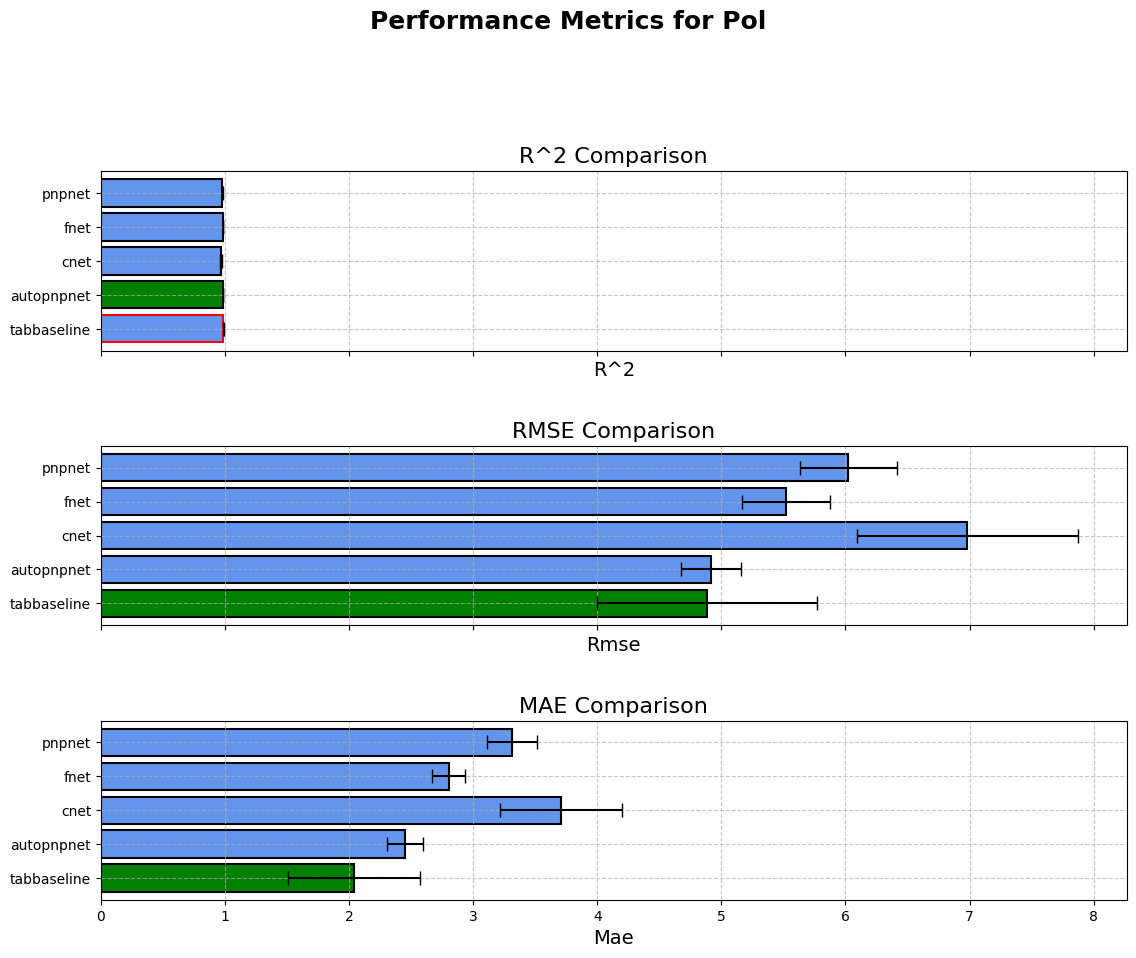

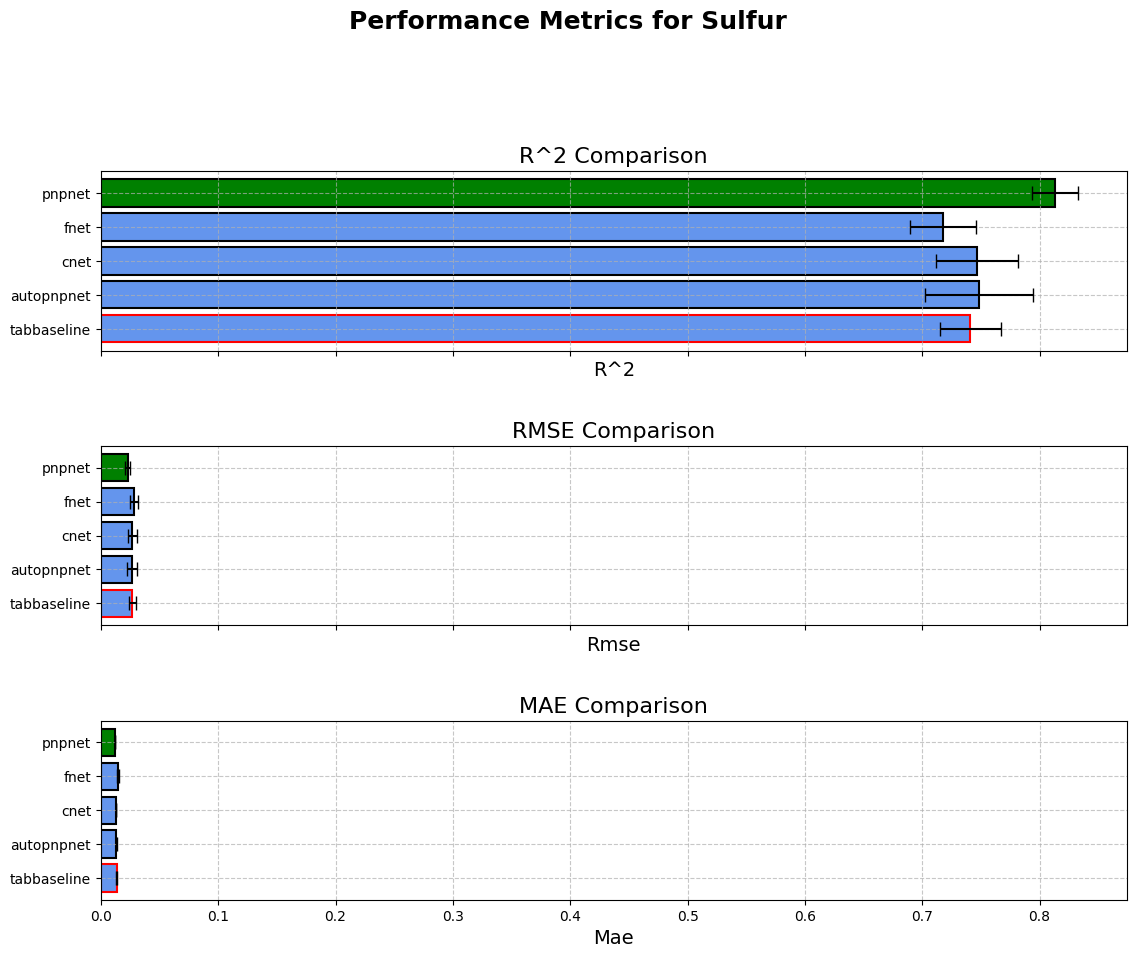

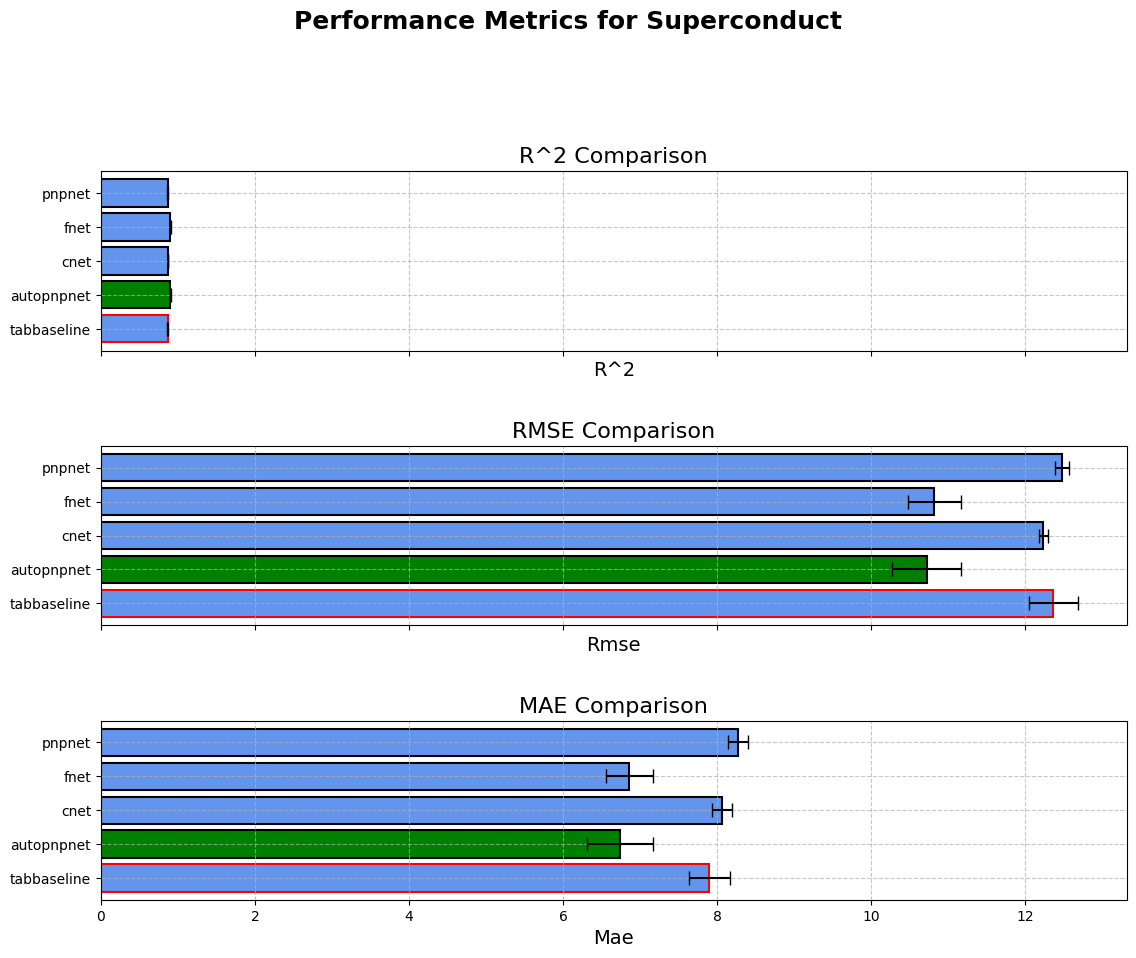

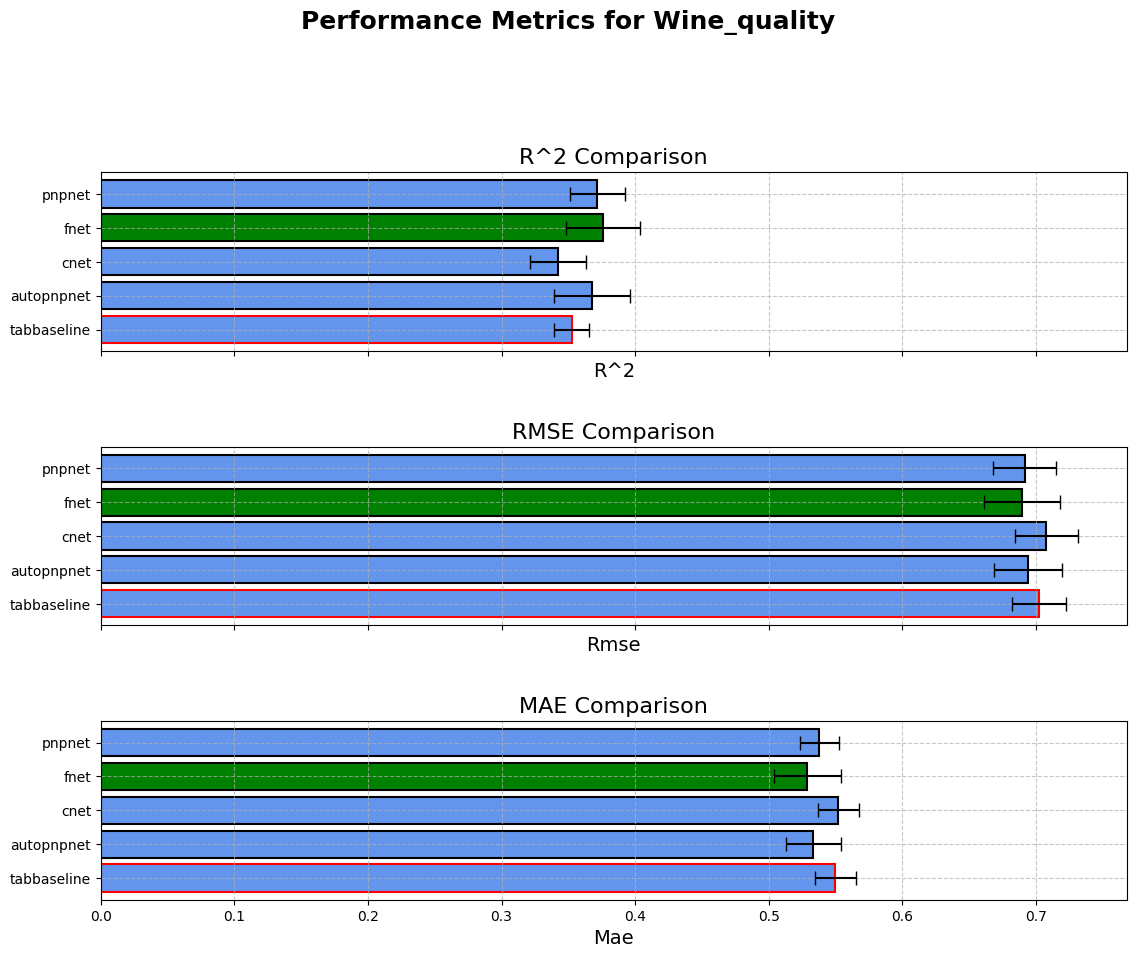

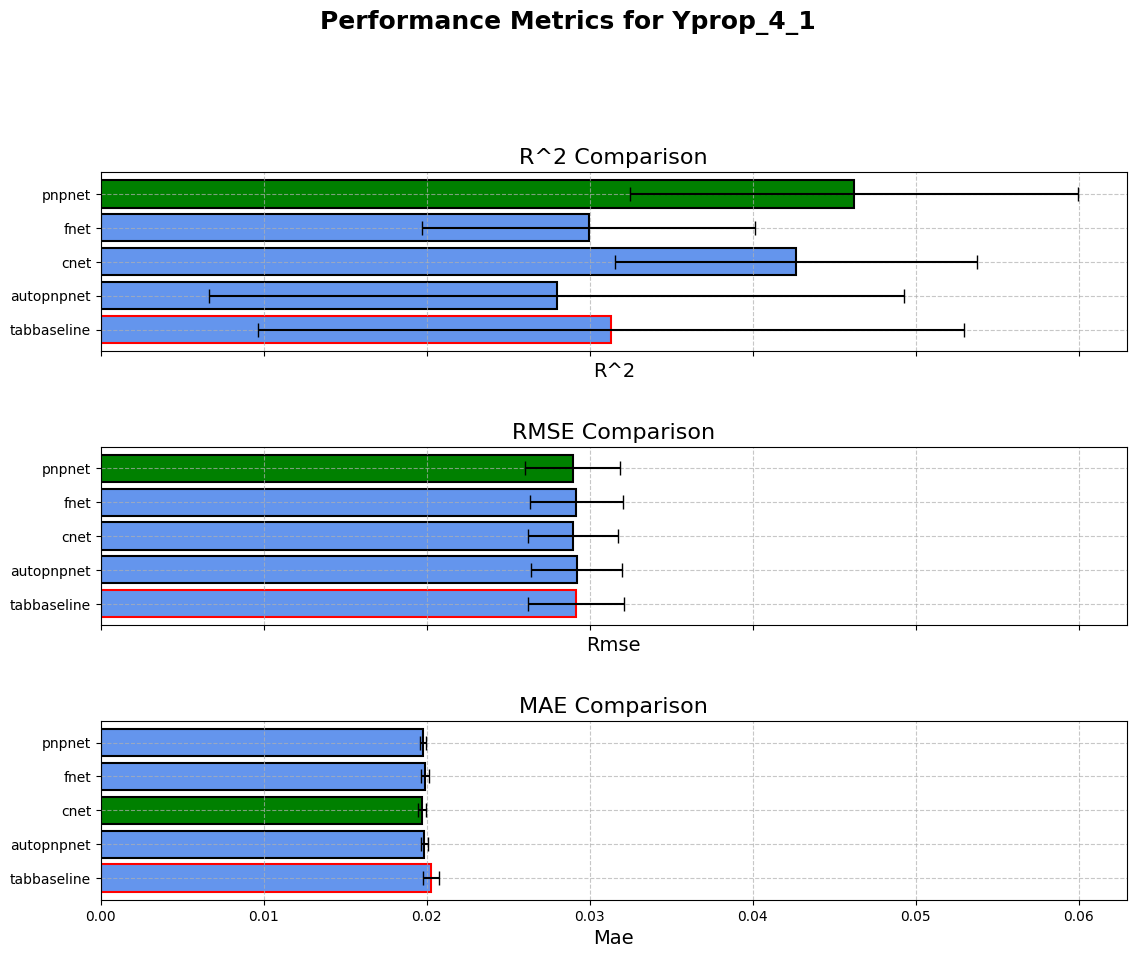

In [4]:
import json
import os
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd

# Constants
TASK = "reg"
DATA_TYPE = "num"
EXPERIMENT_ID = f"benchmark_{DATA_TYPE}_{TASK}"
LOG_DIR = os.path.join("..", "results", EXPERIMENT_ID)
REGRESSION_METRICS = ["R^2", "RMSE", "MAE"]
CLASSIFICATION_METRICS = ["Accuracy", "Precision", "Recall", "F1 Score"]
METRICS = REGRESSION_METRICS if TASK == "reg" else CLASSIFICATION_METRICS

# Utility Functions
def load_metrics(json_path):
    """Load and return metrics from a JSON file, handling exceptions gracefully."""
    try:
        with open(json_path, 'r') as f:
            return json.load(f)
    except (json.JSONDecodeError, FileNotFoundError) as e:
        print(f"Error loading {json_path}: {e}")
        return {}

def aggregate_metrics(log_dir):
    """Aggregate metrics from all experiment folders."""
    summary = []
    for folder in glob(f"{log_dir}/*__*"):
        dataset, model = os.path.basename(folder).split("__", 1)
        model = model.split("_")[0]
        fold_metrics = [load_metrics(file) for file in glob(f"{folder}/*_metrics.json")]
        fold_metrics = [fm for fm in fold_metrics if fm]  # Filter out empty dicts

        if fold_metrics:
            metrics_df = pd.DataFrame(fold_metrics)
            avg_metrics = metrics_df.mean().to_dict()
            std_metrics = metrics_df.std().to_dict()
            avg_metrics.update({"dataset": dataset, "model": model})
            std_metrics.update({"dataset": dataset, "model": model})
            summary.append((avg_metrics, std_metrics))

    avg_summary_df = pd.DataFrame([s[0] for s in summary])
    std_summary_df = pd.DataFrame([s[1] for s in summary])
    return avg_summary_df, std_summary_df

def calculate_percentage_improvement(best_value, baseline_value, metric):
    """Calculate the percentage improvement for a metric, accounting for direction of better values."""
    if baseline_value == 0:
        return None
    improvement = (best_value - baseline_value) / abs(baseline_value) * 100
    return improvement if metric in ["R^2"] + CLASSIFICATION_METRICS else -improvement

def print_and_save_percentage_improvements(avg_summary_df, baseline_model="tabbaseline"):
    """Print percentage improvements and save them to a CSV file."""
    improvement_data = []  # List to store improvement results for CSV saving

    for dataset, data in avg_summary_df.groupby("dataset"):
        baseline_row = data[data["model"] == baseline_model]
        if baseline_row.empty:
            print(f"No baseline model data for dataset {dataset}")
            continue

        print(f"\nDataset: {dataset}")
        baseline_row = baseline_row.iloc[0]

        for metric in METRICS:
            baseline_value = baseline_row[metric]
            best_row = data.loc[
                data[metric].idxmax() if metric in ["R^2"] + CLASSIFICATION_METRICS else data[metric].idxmin()]
            best_model, best_value = best_row["model"], best_row[metric]

            if best_model != baseline_model:
                improvement = calculate_percentage_improvement(best_value, baseline_value, metric)
                improvement_data.append({
                    "dataset": dataset,
                    "metric": metric,
                    "best_model": best_model,
                    "baseline_model": baseline_model,
                    "improvement_percentage": improvement
                })
                print(f"  {metric} - {best_model} improvement over {baseline_model}: {improvement:.2f}%")

    # Save the improvement data to a CSV file
    improvement_df = pd.DataFrame(improvement_data)
    improvement_df.to_csv(f"improvement_summary_{EXPERIMENT_ID}.csv", index=False)

def get_colors_and_edges(models, best_idx, highlight_model="tabbaseline"):
    """Assign colors and edge colors for models, highlighting best and baseline models."""
    colors, edges = [], []
    for idx, model in enumerate(models):
        if idx == best_idx:
            colors.append('green')  # Highlight best model
            edges.append('black')
        elif model == highlight_model:
            colors.append('cornflowerblue')  # Regular color for "tabbaseline"
            edges.append('red')  # Red edges for baseline
        else:
            colors.append('cornflowerblue')
            edges.append('black')
    return colors, edges

def plot_metrics_per_dataset(avg_summary_df, std_summary_df):
    """Plot R^2, RMSE, and MAE metrics with error bars for each dataset."""
    for dataset, data in avg_summary_df.groupby("dataset"):
        # Filter std_data to match the order of data's models
        std_data = std_summary_df[std_summary_df["dataset"] == dataset]
        data = data.set_index("model").loc[sorted(data["model"], key=lambda x: (x != "tabbaseline", x))].reset_index()
        std_data = std_data.set_index("model").loc[data["model"]].reset_index()

        # Ensure std_data and data have matching lengths for error bars
        if len(data) != len(std_data):
            print(f"Warning: Mismatched data and std_data lengths for dataset '{dataset}'. Skipping plot.")
            continue

        fig, axes = plt.subplots(len(METRICS), 1, figsize=(12, 10), sharex=True)
        fig.suptitle(f"Performance Metrics for {dataset.capitalize()}", fontsize=18, weight='bold')

        for i, metric in enumerate(METRICS):
            ax = axes[i]
            values, errors = data[metric].values, std_data[metric].values
            models = data["model"].values

            # Check that the length of errors matches values
            if len(values) != len(errors):
                print(f"Warning: Metric '{metric}' in dataset '{dataset}' has mismatched values and errors.")
                continue

            best_idx = values.argmax() if metric in ["R^2"] + CLASSIFICATION_METRICS else values.argmin()
            colors, edges = get_colors_and_edges(models, best_idx)

            ax.barh(models, values, xerr=errors, color=colors, edgecolor=edges, capsize=5, linewidth=1.5)
            ax.set_title(f"{metric.upper()} Comparison", fontsize=16)
            ax.set_xlabel(metric.capitalize(), fontsize=14)
            ax.grid(True, linestyle='--', alpha=0.7)

        plt.tight_layout(pad=3.0, rect=[0, 0, 1, 0.95])
        plt.show()

def count_top_models(avg_summary_df, baseline_model="tabbaseline"):
    """Count top-performing models across datasets, excluding the baseline model."""
    top_counts = {metric: {} for metric in METRICS}
    total_datasets = avg_summary_df["dataset"].nunique()

    for dataset, data in avg_summary_df.groupby("dataset"):
        for metric in METRICS:
            best_model = data.loc[
                data[metric].idxmax() if metric in ["R^2"] + CLASSIFICATION_METRICS else data[
                    metric].idxmin()]["model"]
            if best_model != baseline_model:
                top_counts[metric].setdefault(best_model, 0)
                top_counts[metric][best_model] += 1

    totals = {metric: sum(counts.values()) for metric, counts in top_counts.items()}
    return top_counts, totals, total_datasets

# Run the analysis
if __name__ == "__main__":
    avg_summary_df, std_summary_df = aggregate_metrics(LOG_DIR)
    print("Aggregated Results (Averages):")
    print(avg_summary_df)

    top_counts, totals, total_datasets = count_top_models(avg_summary_df)
    print("\nNon-baseline models achieving top performance per metric:")
    for metric, counts in top_counts.items():
        print(f"\n{metric}:")
        for model, count in counts.items():
            print(f"  {model}: {count}/{total_datasets} datasets")
        print(f"  Total non-baseline top performers for {metric}: {totals[metric]}/{total_datasets} datasets")

    print("\nPercentage improvements of top-performing models relative to the baseline:")
    print_and_save_percentage_improvements(avg_summary_df)

    avg_summary_df.to_csv(f"summary_{EXPERIMENT_ID}.csv", index=False)
    plot_metrics_per_dataset(avg_summary_df, std_summary_df)
